# An hands-on introduction to medical image segmentation with Multi-task U-Net
*Riccardo De Feo, riccardo.defeo@uef.fi*, [KUBIAC](https://blogs.uef.fi/kubiac/)
![dfg](img/logos.png)

![Segmentation](img/screenshot.png)
In this tutorial we will go over [an implementation of ](https://github.com/Hierakonpolis/MU-Net) [MU-Net](https://www.biorxiv.org/content/10.1101/2020.02.25.964015v1), a multi-task segmentation neural network developed for mouse brain MRI. We will examine the code of Multi-task U-Net, try to understand what it's doing, and train it on new data.

For this tutorial we will assume some knowledge of python basics: we will not go over the concepts of *functions*, *classes*, numpy basics. To run each cell you can select "run" in the top of this window, or press shift+enter. Comapred to the previous tutorial, this time we will focus more on the code. Make sure to read the comments!

Training this network requires a powerful enough workstation with GPU support, and time, but don't be afraid. We will also provide a savepoint for the trained network. If you do not possess a CUDA enabled GPU and wish to run our code, change the *device* variable in the followind cell to 'cpu':

In [1]:
import nibabel as nib           # To open nii files
import numpy as np              # Numerical computation library for python
import torch, torchvision       # Our deep learning framework
import matplotlib.pyplot as plt # To visualize plots and images

# If CUDA is not available, use 
#device='cpu'
device='cuda'

## Data

MU-Net was originally trained and tested with a large dataset of mouse MR images. We cannot openly share this data, so for the purposes of this demostration we will use the 10 [in vivo templates for multi-atlas segmentation](https://github.com/dancebean/multi-atlas-segmentation) released by Da Ma. Let's take a look:

In [2]:
# To read a nifti volume, we use the nib.load function:
Vol=nib.load('in_vivo/template/A0.nii.gz')
# To get the data from this object, we use the get_fdata() method.
# We can safely overwrite the Vol variable:
Vol=Vol.get_fdata()

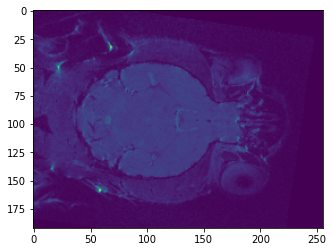

In [3]:
# Using this notation we can select a slice from the MRI volume:
plt.imshow(Vol[:,:,50])

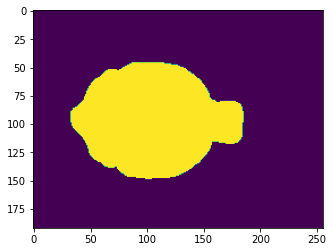

In [4]:
# Let us now look at the brain mask for the same slice:

Mask=nib.load('in_vivo/mask/A0.nii.gz').get_fdata()
plt.imshow(Mask[:,:,50])

(192, 256, 96)

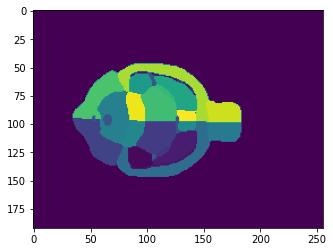

In [5]:
# And the labels:

Lab=nib.load('in_vivo/label/A0.nii.gz').get_fdata()
plt.imshow(Lab[:,:,50])

# Let's also look at the size of our scans:
Vol.shape

The brain mask is represented as a binary mask, where 1 indicates brain voxels. The label volume indicates each region of interest (ROI) with a different integer. 

We are now going to build our dataset object. PyTorch provides an handy dataset class we are about to use. The plan is to build a list of samples one at a time, pre-loading each of them in RAM memory. This should speed up the training process, making the data readily available. We could also load them only when needed, and that is unavoidable for large datasets, but in this case we don't need to.

As you can see, most of the volume is not occupied by the brain. We will use the mask to crop each volume to the brain area. This will greatly reduce the GPU memory requirements for each volume, and allow us to process one entire brain at a time, instead of using a patch-based approach. For a new volume, we can infer the bounding box to crop the volume itself with a simpler and less accurate network, before feeding it into our main network.

In [6]:
# First of all, a function to quickly return
# the data content from each MRI volume:

def niload(path):
    """
    Returns a numpy object from the nifti file path

    Parameters
    ----------
    path : str
        Path to the nifty file.

    Returns
    -------
    new : numpy.ndarray
        Nifti volume as a numpy object.

    """
    nob=nib.load(path, keep_file_open=False)
    data=nob.get_fdata()
    return data

# And now a function to crop the volume to the brain mask, with a small margin.
# This function will find the boundaries around the brain mask

def Box(Mask):
    S=Mask.shape
    LowX=0
    while np.sum(Mask[LowX,:,:])==0:
        LowX+=1
    
    LowY=0
    while np.sum(Mask[:,LowY,:])==0:
        LowY+=1
    
    LowZ=0
    while np.sum(Mask[:,:,LowZ])==0:
        LowZ+=1
    
    HighX=S[0]-1
    while np.sum(Mask[HighX,:,:])==0:
        HighX-=1
    
    HighY=S[1]-1
    while np.sum(Mask[:,HighY,:])==0:
        HighY-=1
        
    HighZ=S[2]-1
    while np.sum(Mask[:,:,HighZ])==0:
        HighZ-=1
        
    return LowX, HighX+1, LowY, HighY+1, LowZ, HighZ+1

# The following function will use them to crop a volume:

def Crop(vol,lims):
    LowX, HighX, LowY, HighY, LowZ, HighZ = lims
    
    return vol[:,LowX:HighX,LowY:HighY,LowZ:HighZ]

We can now provide a simple function to add each data point to a list. As we do that, we will need to convert each volume to a PyTorch format. PyTorch represents volumes in the **[Batch, Channels, Depth, Height, Width]** format.

### One-hot encoding

We will also need to reorganize the information about the labels. These labels represent separate, mutually exclusive categories. Rather than trying to predict a different number for each voxel, we will organize them as different channels. A different way to phrase this is to think of a 1-hot label vector for each voxel: a vector where each position refers to a different category, with the correct one being indicated as 1. If we had 5 categories, this would mean that for each voxel:

0 → [1,0,0,0,0]

3 → [0,0,0,1,0]

In [7]:
def AddVolume(dataset,labels,mask,template,crop=True):
    """
    Append a data sample to the dataset list, given the path of MRI, labels,
    and brain mask.
    
    Parameters
    ----------
    dataset : list
        List the sample is appended to.
    labels : string
        Path to the labels volume, in atlas format (one value for each ROI).
    mask : string
        Path to the mask volume.
    template : string
        Path to MRI volume.

    Returns
    -------
    None.

    """
    # We load each volume in RAM
    L=niload(labels)
    M=niload(mask)
    MRI=niload(template)
    
    # LAB will be a container for our category labels
    # We have 38 unique categories, including background
    # These volumes will be shaped [Channels, Depth, Height, Width].
    # We will add the batch axis later
    
    # Build a zeros volume with the same shape
    # as the original, and 38 channels
    
    LAB=np.zeros([38]+list(L.shape)) 
    
    # Add the channel dimension to the brain mask
    # by using the reshape function.
    
    M=M.reshape([1]+list(M.shape))
    
    # Reshape the MRI volume to the same shape,
    # thus adding a channel axis. As a grayscale
    # image, the MRI scan only has a single channel:
    # only one imaging modality
    
    MRI=MRI.reshape(M.shape)
    
    # We will now interate through each ROI.
    # Numbers 37,30 and 22 are unused in
    # the label volume, ranging up to 40.
    # We will skip those using the 
    # subtract variable.
    subtract=0
    
    # For each indicated ROI:
    for k in range(int(L.max())+1):
        # Skip over unused values
        if k in [37,30,22]:
            subtract+=1
            continue
        # Empty temp volume
        temp=np.zeros_like(L)
        # Set to 1 for each element labeled as k
        # k=0 represents the background class
        temp[L==k]=1 
        # Assign that to the next channel in LAB
        LAB[k-subtract,:,:,:]=temp
        
    # We can now use the cropping functions to crop these volumes
    
    if crop:
        
        boundaries = Box(M[0,:,:,:])
        
        M  =Crop(M,boundaries)
        MRI=Crop(MRI,boundaries)
        LAB=Crop(LAB,boundaries)
    
    # Each sample with be saved as a dictionary
    # with each entry indicating different types of data
    dataset.append({'template':MRI,
                    'mask':M,
                    'label':LAB,
                    'path':template})

A drawback of this strategy is that each volume will have a different shape. In this case this will not be a problem, as we do not have enough memory to process more than one volume at the same time, but in general we might want to concatenate multiple volumes together over the batch dimension, and for that we would need them to have the same size.

We can now build a custom wrapper for our dataset by using the PyTorch dataset class. This class requires, at the very least:
1. A **\__len__** method, to define the number of samples in the dataset;
2. A **\__getitem__** method, to return each sample when indexing the Dataset object;
3. An **\__init__** method, where we will collect our data.

We will also reserve some space for a transform object, a function that will be executed on each sample as it is extracted. More on that later.

In [8]:
# We will need to crawn through our data folder.
# For that we will use the os library

import os
    
# Define a new class, starting from the Dataset class:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,datafolder='in_vivo',transform=None,maxsamples=np.inf):
        """
        The __init__ function is run when the class is instantiated 
        
        Parameters
        ----------
        datafolder : string
            Path to the data folder, containing the template, mask and label
            folders.
        transform : transform function, optional
            A transform function or torchvision.transforms.Compose composition of transforms.
            The default is None.
        maxsamples : any number
            Max number of samples to acquire, useful if you have limited RAM memory
            and still want to run this code

        Returns
        -------
        None.

        """
        
        self.dataset=[]
        self.transform=transform
        
        # For each file in the template folder
        for file in os.scandir(os.path.join(datafolder,'template')):
            # If it's a nifti file
            if 'nii.gz' in file.name:
                # We take the respective files from the mask and label folder
                name=file.name
                mri=file.path
                labels=os.path.join(datafolder,'label',name)
                mask=os.path.join(datafolder,'mask',name)
                
                AddVolume(self.dataset, labels, mask, mri)
                
                # 
                
                if len(self.dataset)>=maxsamples: break
        
    
    def __len__(self):
        """
        Lenght of the total dataset. Our default lenght method
        will be the same of the python list we use for the dataset

        Returns
        -------
        int
            Number of elements in dataset.

        """
        return len(self.dataset)
    
    def __getitem__(self,idx):
        """
        Extract one dataset item, identified by its index in the list.
        This method will be used when training our network

        Parameters
        ----------
        idx : int
            Position of desired element in dataset list.

        Returns
        -------
        sample : dict
            Dictionary of MRI, Labels and Mask for sample idx.

        """
        # By using the copy method from numpy, we will make sure
        # not to replace our original dataset items
        # when applying transforms
        sample=self.dataset[idx].copy()
        
        #We apply our transforms, we will explain this step later
        if self.transform:
            sample = self.transform(sample)
        
        return sample

Let's instatiate it and look at its contents. For now let's limit the number of samples, to run the next cell faster and to keep RAM usage low:

In [9]:
dataset=Dataset(maxsamples=1)

We can access all data samples by simply indexing this dataset object. Later on, we will iterate over this dataset using the wrappers offered by PyTorch. Before that, however, let's build our neural network classes.

For each samples we have dictionary keys:
 dict_keys(['template', 'mask', 'label', 'path'])


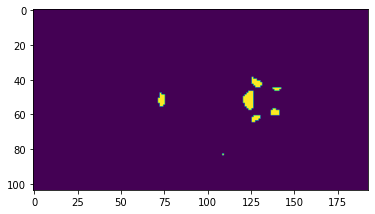

In [10]:
print('For each samples we have dictionary keys:\n',dataset[0].keys())
plt.imshow(dataset[0]['label'][10,:,:,50])

We will also need the labels for each ROI:

In [11]:
labels=['Brain Mask',
         'Background',
         'Hippocampus R',
         'External Capsule',
         'Caudate Putamen R',
         'Anterior Commissure R',
         'Globus Pallidus R',
         'Internal Capsule R',
         'Thalamus R',
         'Cerebellum R',
         'Superior Colliculi R',
         'Ventricles',
         'Hypothalamus R',
         'Inferior Colliculi R',
         'Central Gray R',
         'Neocortex R',
         'Amygdala R',
         'Olfactory bulb R',
         'Brain Stem',
         'Rest of Midbrain R',
         'Basal Forebrain Septum R',
         'Fimbria R',
         'Hippocampus L',
         'Caudate Putamen L',
         'Anterior Commissure L',
         'Globus Pallidus L',
         'Internal Capsule L',
         'Thalamus L',
         'Cerebellum L',
         'Superior Colliculi L',
         'Hypothalamus L',
         'Inferior Colliculi L',
         'Central Gray L',
         'Neocortex L',
         'Amygdala L',
         'Olfactory bulb L',
         'Rest of Midbrain L',
         'Basal Forebrain Septum L',
         'Fimbria L']

### Transforms
Using these functions, we can apply a number of transformation on our input data just before each sample is extracted from the dataset. We can use this to perform data augmentation, or simply to turn a numpy object in a PyTorch tensor.

All we need is to define them as functions or function classes.

#### Rescaling
We can generate new realistic training samples from the ones we have. This is not as good as having a larger training set, but it will hopefully allow us to better represent the overall distribution of unknown samples. We can expect, for example, that a new volume might appear slightly different in size. For this, we will apply a random rescaling transformation:

In [12]:
# To scale 3D volumes, we will use the zoom function from scipy
from scipy.ndimage.interpolation import zoom
import random

class Rescale():
    """
    Rescale the volumes to a given size.
    """

    def __init__(self, MaxScale,MinScale,probability):
        
        # As we define our transformation class,
        # we will decide on a probability of applying it
        # and on the minimum and maximum scale factor
        
        self.MinScale = MinScale
        self.span = MaxScale-MinScale
        self.probability=probability

    def __call__(self, sample):
        
        # First we decide whether to apply the transformation
        # with the specified probability
        
        if random.random()<self.probability:
            
            # We randomly pick a scale factor in the given range
            scaleFactor=self.MinScale + self.span * random.random()
            scaleFactor=(1,scaleFactor,scaleFactor,scaleFactor)
            
            # Let's apply the transformations.
            # For the MRI volume, we can interpolate with order 3
            sample['template']=zoom(sample['template'],scaleFactor,order=3)
            
            # We need to preserve the label information as integers:
            # we will use neares enighbor interpolation, order 0
            
            sample['mask']=zoom(sample['mask'],scaleFactor,order=0)
            
            # We will need to process each channel separately
            # for the label volume
            scaleFactor=scaleFactor[-3:]
            # build a new container volume
            shape=list(sample['mask'].shape)
            shape[0]=sample['label'].shape[0]
            newL=np.zeros(shape)
            
            # fill the volume
            for k in range(sample['label'].shape[0]):
                newL[k,:,:,:]=zoom(sample['label'][k,:,:,:],scaleFactor,order=0)
            sample['label']=newL
        
        return sample

#### Multiprocessing warning!

PyTorch allows us to load data in parallel by using multiple workers. When using random numbers and parallel processing, the random seed may be reinitialized to the same value at every iteration if you are using the random number generator from NumPy. The builtin random number generator from Python or PyTorch do not seem to suffer from this issue.

#### Normalization
This is an important step for many neural networks: we standardize the input to a standard space. This will remove any units the input is measured in, and give us a quantity more compatible with the weights of the neural network. Often this will in turn simplify the choice of hyperparameters: those parameters we are not directly optimizing for during gradient descent. The more robust our system is to the choice of hyperparameters, the better.

![Normalization](img/normalize.png)
In MRI, we have an additional reson for this step: we have no guarantee that the voxel values of different scan will change in the same range. Imaging techniques are often non-quantitative, and were primarily designed for the eye of the radiologist. Contrast and clarity are often prioritized over the specific numeric values. As this can change from scan to scan, we will not normalize the inputs over the entire dataset, but we will normalize each volume individually.

We will set the inputs to have 0 mean and variance 1. Note, however, that this step is not enough to bridge the gap between different MRI scanners, as that tipically comes with deeper changes in the data depending on vendor and experimental setup.

In [13]:
class Normalizer():
    
    def __call__(self,sample):
        
        mean=np.mean(sample['template'])
        std=np.std(sample['template'])

        sample['template']=(sample['template'] - mean)/(np.sqrt(std))
        return sample

#### PyTorch Tensors

Eventually we need to transform our numpy objects into PyTorch tensors, and assign them to RAM or GPU memory, depending on whether we are working with the CPU or the GPU. 

In [14]:
class ToTensor():
    
    def __init__(self,device=device):
        self.device=device
    
    def __call__(self,sample):
        for k in ['template','mask','label']:
            # Using the from_numpy method we can
            # quickly transform numpy arrays
            # to pytorch tensors
            sample[k] = torch.from_numpy(sample[k]).float().to(self.device)
        
        return sample

## Network

Time to build our neural network. We will use a simple multi-task U-Net and explain each option as it is defined. The way this network is built will appear more complex than it needs to be, however it will allow for some extra flexibility when comparing different architectures. First of all, let's take a look at the overall structure:

![Neural network architecture](img/net.png)

*From the [Multi-task U-Net](https://www.biorxiv.org/content/10.1101/2020.02.25.964015v1) paper, simplified.*

The name *U-Net* comes from the shape of this network as you can see above. If we ignore the purple arrows (skip + concat) for a moment, what is left would be an encoder/decoder architecture. The left branch, called encoder branch, would downscale the input and extract the relevant information to feed through the bottleneck at the bottom. The decoder branch, on the right, would build up from the bottleneck layer to build our output from the information extracted.

The U-Net architecture adds *skip-connections* between each level of the encoder branch and the decoder branch. These allow information to flow between encoder and decoder branch at every level of resolution, changing the encoder/decoder architecure in a fundamental way.

In its original implementation, every convolutional layer include 64 filters. In this case we are rather short on available GPU memory, so we will apply less filters in the first and second layers. As the parametric maps are larger on the first layers, decreasing the number of filters here will have a large impact on memory usage.

Let's define a dictionary outlining the parameters of our network, and after that we will start defining each operation:

In [15]:
from torch import nn

PARAMS={'Categories':38, # Number of categories, including background
        'FilterSize':3, # each single filter will be 3x3
        'FiltersNum':np.array([32, 32, 64, 64]), # From top to bottom, number of filters
        
        # In the paper we use a larger number of parameters
        # For this tutorial the number has been reduced, so that the model
        # could run on an high-end desktop
        # insted of requiring a Tesla P100 GPU
        
        # number of filters for the last convolutional layer before splitting into different tasks    
        'ClassFilters':int(64), 
        'Activation':nn.LeakyReLU,  # Activation function
        'InblockSkip':False, # We will not use in-block skip connection for this tutorial
        'PoolShape':(2,2,2), #Shape of the pooling operation
        # PyTorch classes used for each of type of layer:
        'BNorm':nn.BatchNorm3d,
        'Conv':nn.Conv3d,
        'Pool':nn.MaxPool3d,
        'Unpool':nn.MaxUnpool3d,
        }

# As a default tensor type, we will use float numbers
# Using double precision numbers would result in greater
# memory usage, for no significant benefit
if device == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

We already discussed convolution and pooling in the previous tutorial. Now it's time to introduce two new operations: unpooling and batch normalization.

### Unpooling

In the decoder branch, we will need to upscale our parametric maps back up to the same shape of the input layers. We have three main strategies to do this: up-convolution, interpolation and unpooling.

By interpolation we refer to simply upscaling each parametric map doing something, in principle, no different from what we did to resize the inputs earlier on. In a preliminary testing phase we found this to yield slightly less accurate results compared to unpooling, however this result is problem dependent and not general at all.

Up-convolution, also referred to as transpose convolution, is a more complex operation depending on a significant number of new weight parameters. It is also far slower compared to unpooling, and at this point many works in recent literature replaced it with either unpooling or interpolation layers.

<img src="img/Pooling-and-unpooling.jpg"/>

*Source: [Eli David, Nathan S. Netanyahu 2017](https://arxiv.org/abs/1711.08763) [DeepPainter: Painter Classification Using Deep Convolutional Autoencoders](https://www.researchgate.net/figure/Pooling-and-unpooling-layers-For-each-pooling-layer-the-max-locations-are-stored-These_fig2_306081538)*

By unpooling we refer to inverting a specific max-pooling operation. In the pooling layer, as we select the maximum for each 2x2x2 domain of its input, we will save the position of each selected element. In this way we can take any parametric map of the same size as the output of the pooling operation, and simply bring it to the same size as the input of the pooling layer by placing its elements to the same position of those elements selected when max-pooling. It may sound far more confusing than it is, and a brief look at the picure above should make it clearer.

One of the drawbacks of unpooling is of course that it requires a corresponding max-pooling operation, and so we cannot replace it with a strider convolution, average pooling, or some other alternative strategy we might want to try.

### Batch Normalization

A little while ago we normalized the input data for our network. We can imagine that each layer is, from the point of view of the following layers, simply the input of the rest of the network. In fact, the data distribution of this input is constantly shifting during the training process. It would be easier to train our network if we kept the statistics of each layer under control. We refer to this phenomenon as covariate shift, and we mitigate it by using normalization throught the network. 

In this case, the mean and variance are learned parameters, and may differ from 0 and 1. Batch normalization will normalize inputs across the entire batch, which in this case only contains one sample. This is again similar to what we did for the inputs.

### Leaky ReLU

With the exception of the output layers, we will use the leaky ReLU activation function. Like the ReLU, for positive inputs we return the input itself. For negative inputs instead of 0 we return a small value, in this case 0.01*input. 

In this way, even when the unit is not active we will still generate a gradient.

![Leaky ReLU](img/leakyreluformula.png)

![Leaky ReLU](img/LeakyReLU.png)

*Source: [PyTorch documentation](https://pytorch.org/docs/stable/nn.html#leakyrelu)*

## Defining the network

We will use padding for every convolution, to keep the map size constant. As we are defining the network parameters in an external dictionary, we can define a function to automatically find how much padding we need. As we are assuming a stride of 1 for all convolutions, we can simply use:

In [16]:
def FindPad(FilterSize):
    """
    Returns appropriate padding based on filter size.
    Input can be int, tumple, or numpy array
    
    By using an array, we can define convolution kernels
    of any size, for example (3,5,7). 
    However, this is not a common choice.
    """
    A=(np.array(FilterSize)-1)/2
    if type(FilterSize)==tuple:
        return tuple(A.astype(int))
    else:
        return int(A)

With this we can start defining our convolution layers. As we have max-pooling layers, it makes more sense to apply our activation function *after* the pooling, as that would involve less elements, and so it will be more efficient. We just need to make an exception for the first layer, operating on the input.

To define a neural network or a part thereof in PyTorch we need to define a class that will initialize each layer with its init. This will initialize all the weights and parameters. Then we will need a forward method for this class, where we will combine the layers we just defined.

In [17]:
class OneConv(nn.Module):
    """
    Performs one single convolution: activation of previous layer, batchnorm,
    convolution
    FilterIn is the number of input channels, FilterNum output channels,
    PAR is the parameters dictionary, containing the classes we need
    
    We will control the filter size separately, as we will need to 
    change it for certain layers
    """


    def __init__(self,FilterIn,FilterNum, FilterSize,PAR):
        super(OneConv,self).__init__()
        
        # To avoid applying LeakyRELU on the input directly
        # we will define the activation as a identity function
        # if the input only includes one channel. Otherwise,
        # we will use the functions we chose previously.
        # We do the same for batch normalization.
        
        if FilterIn == 1:
            self.activate= lambda x: x
            self.norm= lambda x: x
        else:
            # Activation: 
            self.activate=PAR['Activation']()
            
            # When defining batch norm we need to expliciply
            # specify the number of input channels:
            self.norm=PAR['BNorm'](int(FilterIn))
        
        # For the convolution itself, we need to specify the
        # number of input and output channels, the size of
        # the filters, and the padding. We will find the padding
        # using the function we define earlier
        
        self.conv=PAR['Conv'](int(FilterIn),int(FilterNum),FilterSize,padding=FindPad(FilterSize) )
        
    def forward(self,layer):
        
        # With layer as the input:
        
        act=self.activate(layer)      # activation
        normalize=self.norm(act)      # normalization
        convolve=self.conv(normalize) # convolution
        
        return convolve

The bottleneck layer, green arrow in the illustration above, will be defined in a similar way:

In [18]:
class Bottleneck(nn.Module):
    
    def __init__(self,FilterIn,FilterNum,FilterSize,PAR):
        super(Bottleneck,self).__init__()
        self.norm=PAR['BNorm'](int(FilterIn))
        self.conv=PAR['Conv'](int(FilterIn),int(FilterNum),FilterSize,padding=FindPad(FilterSize) )
        
    def forward(self,layer):
        normalize=self.norm(layer)
        convolve=self.conv(normalize)
        return convolve

We are almost done with defining our sub-modules. Based on the presence or absence of skip connections inside each convolution block, we define two different convolution blocks. In the presence of skip-connections, we will need to define a larger number of input channels for the second and third layers in the block, to include the outputs of the previous layers. In any case, the last size 1 convolution will bring down again the number of channels.

In [19]:
class SkipConvBlock(nn.Module):
    """
    One full convolution block with skip connections
    FilterIn is the number of input channels, FilterNum output channels,
    filters are of size FilterSize
    """

    def __init__(self,FilterIn,FilterNum,FilterSize,PAR):
        super(SkipConvBlock,self).__init__()
        
        # We can now use the convolution module
        # we defined earlier to define all convolutions
        # inside the block
        
        self.conv1=OneConv(int(FilterIn),int(FilterNum),FilterSize=FilterSize,PAR=PAR)
        self.conv2=OneConv(int(FilterIn+FilterNum),int(FilterNum),FilterSize=FilterSize,PAR=PAR)
        self.conv3=OneConv(int(FilterIn+FilterNum*2),int(FilterNum),1,PAR=PAR)
        
    def forward(self,BlockInput):
        first=self.conv1(BlockInput)
        fconv=torch.cat((first,BlockInput),1)
        
        # in this case we use torch.cat to concatenate
        # the outputs of the different convolution blocks
        
        second=self.conv2(fconv)
        sconv=torch.cat((first,second,BlockInput),1)
        
        BlockOut=self.conv3(sconv)
        
        return BlockOut
    
class NoSkipConvBlock(nn.Module):
    """
    One full convolution block without skip connections
    FilterIn is the number of input channels, FilterNum output channels,
    filters are of size FilterSize
    """

    def __init__(self,FilterIn,FilterNum,FilterSize,PAR):
        super(NoSkipConvBlock,self).__init__()
        self.conv1=OneConv(int(FilterIn),int(FilterNum),FilterSize=FilterSize,PAR=PAR)
        self.conv2=OneConv(int(FilterNum),int(FilterNum),FilterSize=FilterSize,PAR=PAR)
        self.conv3=OneConv(int(FilterNum),int(FilterNum),1,PAR=PAR)
        
    def forward(self,BlockInput):
        
        # In this case we just need to feed one layer's 
        # output to the following layer
        
        first=self.conv1(BlockInput)
        second=self.conv2(first)
        BlockOut=self.conv3(second)
        
        return BlockOut

We will now define the full network. Using these short **for** cycles we make sure we can change the architecture just by altering the PAR variable, rather than having to directly change the code inside the network for fine tuning. The downside is that this will make the following code harder to read.

In [20]:
class MUnet(nn.Module):
    """
    Returns (Mask,Classes)
    Generated based on parameters
    """
    
    def __init__(self,PARAMS=PARAMS):
        super(MUnet,self).__init__()
        self.PARAMS=PARAMS
        
        # First of all we choose the conv block
        # based on the presence of skip connections
        if PARAMS['InblockSkip']:
            ConvBlock=SkipConvBlock
            self.skipper=True
        else:
            ConvBlock=NoSkipConvBlock
            self.skipper=False
        
        # We define a dictionary of modules to store
        # the layers we are about to initialize
        
        self.layers=nn.ModuleDict()
        
        # let's start with the encoder modules:
        # One dense block. We need to specify input and 
        # output channels
        
        self.layers['Dense_Down'+str(0)]=ConvBlock(1,
                                                   PARAMS['FiltersNum'][0],
                                                   FilterSize=PARAMS['FilterSize'],
                                                   PAR=PARAMS)
        
        # One pooling layer, returning the indexes of 
        # the pooled items, for layer unpooling
        # We just need to pass on the pooling shape
        
        self.layers['Pool'+str(0)]=PARAMS['Pool'](PARAMS['PoolShape'],return_indices=True) 
        
        # Repeat for each layer. The index i will
        # indicate the depth of the layer, where 
        # larger i means deeper
        
        for i in range(1,len(PARAMS['FiltersNum'])):
            self.layers['Dense_Down'+str(i)]=ConvBlock(PARAMS['FiltersNum'][i-1],
                                                       PARAMS['FiltersNum'][i],
                                                       FilterSize=PARAMS['FilterSize'],
                                                       PAR=PARAMS)
            self.layers['Pool'+str(i)]=PARAMS['Pool'](PARAMS['PoolShape'],return_indices=True) 
        
        # Bottleneck layer
        self.layers['Bneck']=Bottleneck(PARAMS['FiltersNum'][-1],
                                        PARAMS['FiltersNum'][-1],
                                        FilterSize=PARAMS['FilterSize'],
                                        PAR=PARAMS)
        
        # Layers on the decoding path:
        # Unpooling and convolution
        # Unpooling needs us to specify 
        # again the same pooling
        # shape we defined earlier
        
        self.layers['Up'+str(i)]=PARAMS['Unpool'](PARAMS['PoolShape'])
        
        self.layers['Dense_Up'+str(i)]=ConvBlock(PARAMS['FiltersNum'][-1]+PARAMS['FiltersNum'][-1],
                                                 PARAMS['FiltersNum'][-2],
                                                 FilterSize=PARAMS['FilterSize'],
                                                 PAR=PARAMS)
        
        for i in reversed(range(1,len(PARAMS['FiltersNum'])-1)):
            
            self.layers['Up'+str(i)]=PARAMS['Unpool'](PARAMS['PoolShape'])
            
            # The number of input channels here is twice the number of outputs,
            # as we will combine the unpooled maps and the maps from
            # the skip connections coming from the encoding path
            
            self.layers['Dense_Up'+str(i)]=ConvBlock(PARAMS['FiltersNum'][i]*2,
                                                     PARAMS['FiltersNum'][i-1],
                                                     FilterSize=PARAMS['FilterSize'],
                                                     PAR=PARAMS)
            
            
        self.layers['Up'+str(0)]=PARAMS['Unpool'](PARAMS['PoolShape'])
        
        # Generate the last parametric map, with ClassFilters number of channels
        
        self.layers['Dense_Up'+str(0)]=ConvBlock(PARAMS['FiltersNum'][0]*2,
                                                 PARAMS['ClassFilters'],
                                                 FilterSize=PARAMS['FilterSize'],
                                                 PAR=PARAMS)
        
        # Output layers: 
        # Classifier layer:
        # Size 1 convolution with as many channels 
        # as we have different categories
        
        self.layers['Classifier']=PARAMS['Conv'](PARAMS['ClassFilters'],
                                                 PARAMS['Categories'],
                                                 1)
        
        # Binary mask, for skull stripping:
        # Single channel, size 1 convolution
        
        self.layers['BinaryMask']=PARAMS['Conv'](PARAMS['ClassFilters'],
                                                 1,
                                                 1)
        
        # The respective activation functions:
        
        self.softmax=nn.Softmax(dim=1)
        self.sigmoid=nn.Sigmoid()
            
            
    def forward(self,MRI):
        
        # We will store the parametric maps in these dictionaries:
        
        pools={}
        dense={}
        Updense={}
        Unpool={}
        
        # Encoding path:
        # we can overwrite the pooled maps with the output
        # of the following dense block, we will need
        # to keep the rest
        # The pools dictionary contains the 
        # saved indexes from pooling operations
        
        dense[0] = self.layers['Dense_Down'+str(0)](MRI)
        dense[1], pools[0] = self.layers['Pool'+str(0)](dense[0])
        
        for i in range(1,len(self.PARAMS['FiltersNum'])):
            dense[i] = self.layers['Dense_Down'+str(i)](dense[i])
            dense[i+1], pools[i] = self.layers['Pool'+str(i)](dense[i])
        
        # Bottleneck layer
        
        BotNeck = self.layers['Bneck'](dense[i+1])
        
        
        # Deconding path:
        # Unpool:
        
        Unpool[i] = self.layers['Up'+str(i)](BotNeck,pools[i],output_size=dense[i].size())
        
        # Concatenate with the encoded maps.
        
        # Simple operations like this, requiring no
        # parameters and defining no new functions,
        # do not need to be initialized with the class
        # as new layers, and can be applied directly
        # in the forward function.
        
        cat=torch.cat([Unpool[i],dense[i]],dim=1)
        
        # Convolution block:
        Updense[i] = self.layers['Dense_Up'+str(i)](cat)
        
        # Repeat for each layer
        for i in reversed(range(len(self.PARAMS['FiltersNum'])-1)):
            
            Unpool[i]=self.layers['Up'+str(i)](Updense[i+1],pools[i],output_size=dense[i].size())
            cat=torch.cat([Unpool[i],dense[i]],dim=1)
            Updense[i]=self.layers['Dense_Up'+str(i)](cat)
        
        # Output layers
        MultiClass=self.layers['Classifier'](Updense[0])
        MonoClass=self.layers['BinaryMask'](Updense[0])
        
        # Return the activated layers:
        
        return self.sigmoid(MonoClass), self.softmax(MultiClass)

## Loss

We typically evaluate the accuracy of our network using the [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient): twice the size of the intersection between the two volumes divided by the sum of the sized of both volumes. 

![Dice coefficient](img/dice.png)

It makes sense then to build a loss function out of the same metric. For M categories, following [Sudre et al.](https://link.springer.com/chapter/10.1007/978-3-319-67558-9_28):

![Dice loss](img/loss.png)

It seems that optimizing directly for the Dice loss achieves better results than cross entropy. Let's define this loss function using PyTorch operations. 

In [21]:
def DiceLoss(Ytrue,Ypred):
    """
    Returns the Dice loss between predicted and reference torch tensors.
    Order is optional.

    Parameters
    ----------
    Ytrue : torch.tensor
        Reference tensor.
    Ypred : torch.tensor
        Predicted tensor.

    Returns
    -------
    DICE : torch.tensor
        Dice loss, scalar value.

    """

    DICE = -torch.div(
        torch.sum(torch.mul(torch.mul(Ytrue,Ypred),2)),
        torch.sum(torch.mul(Ypred,Ypred)) + torch.sum(torch.mul(Ytrue,Ytrue))
        )
    
    return DICE

# Our network output will be in the form of (Mask,ROIs)
# so let's write a function to evaluate both tasks:

def Loss(Ytrue,Ypred):
    
    return DiceLoss(Ytrue[0],Ypred[0]) + DiceLoss(Ytrue[1],Ypred[1])

## Training the network

Finally, we can start training the network. Let's define the training loop. Training this network can take a long time, so after demonstrating the training loop we will load a savepoint prepared after training the network for 24 hours. If you do not have enough RAM to store the entire dataset, feel free to reduce the number of samples by changing the *Max_Samples* variable in the next cell.

In [22]:
Max_Samples=10

from sklearn.model_selection import train_test_split
import time, tqdm

# We have a small dataset, so we will not validate after every epoch
# to keep training time down. We will test every 5 epochs

testinterval=5 # epochs
maxtime=24 *60*60 # in senconds

# We will use 20% of our dataset as evaluation data

testsize=0.2
Bsize=1 # batch size

# instantiate the network:

UN=MUnet(PARAMS).to(device)

# Let's define the optimizer. We will use Adam, as we did
# in the previous tutorial. We need to pass the network
# parameters we will optimize for

optimizer=torch.optim.Adam(UN.parameters())

# We can now instantiate the transforms we defined earlier
# We will only be downscaling, as we need to keep
# memory usage under control

scaler = Rescale(0.95,0.85,1)
normalizator = Normalizer()
tensorize = ToTensor()

# To combine them in one transform object, we can use
# the Compose function from PyTorch.
# They will be applied in the order listed:

transforms = torchvision.transforms.Compose([ normalizator, scaler,  tensorize])

# Let's redefine the dataset now, using these transforms.

dataset=Dataset(transform=transforms,maxsamples=Max_Samples)

# We can use sklearn to randomly split the dataset 80%-20%
# between training and validation data

train_idxs, test_idxs = train_test_split(np.arange(len(dataset)), test_size=testsize)

print('Training samples: ',train_idxs)
print('Validation samples: ',test_idxs)

Training samples:  [5 6 1 9 2 3 7 0]
Validation samples:  [4 8]


In [23]:
# PyTorch provides the DataLoader class to load samples
# from the dataset. This will add the batch axis, 
# we will also use this to randomize at each epoch 
# the order of the samples extracted

trainloader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=Bsize,
                                          sampler=torch.utils.data.SubsetRandomSampler(train_idxs))
testloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=Bsize,
                                         sampler=torch.utils.data.SubsetRandomSampler(test_idxs))

To visualize the Dice scores we will need a Dice score function, rather than simply using the Dice loss:

In [24]:
def FullDice(Ytrue,Ypred):
    
    # To move a tensor back to numpy, we need to:
    # 1. Detach it from the automatic differentiator
    # 2. Move it to RAM memory
    # 3. Convert to numpy array:
    Mask=Ypred[0].detach().cpu().numpy()
    
    # Threshold the mask output to a binary mask
    Mask[Mask>=0.5]=1
    Mask[Mask!=1]=0
    
    # Take the maximum channel-wise for the ROIs,
    # set the rest to zero
    
    labels=Ypred[1].detach().cpu().numpy()
    labels [np.where(labels== np.amax(labels,axis=1))] = 1
    labels[labels!=1]=0
    
    # Get the Dice scores for brain mask, background and all ROIs:
    Ypred=np.concatenate((Mask,labels),axis=1)
    Ytrue=np.concatenate((Ytrue[0].cpu().numpy(), Ytrue[1].cpu().numpy()),axis=1)
    
    
    dice=2*np.sum(Ytrue*Ypred,(0,2,3,4))/(np.sum((Ytrue+Ypred),(0,2,3,4))+1)
    
    return dice

This system was trained on a GeForce RTX 2080 Ti GPU. If you do not have comparable or superior hardware at your disposal you might not be able to run the next cell. In that case, feel free to skip and continue with the saved model later on, and just read the comments.

In [25]:
# We will keep track of the elapsed time
# using the time library
time_check=time.time()
# Set training mode
UN.train()

TotalTime=0
epoch=0

#initialzie the best loss to an high value
bestloss=np.inf
    
while TotalTime < maxtime:
    
    # We will check the running mean of the loss function
    # on the training set
    
    runloss=[]
    
    # Iterate over the training set, using the dataloader
    
    for i, sample in tqdm.tqdm(enumerate(trainloader),total=len(trainloader)):
        # Clear cache, just in case
        torch.cuda.empty_cache()
        
        # Zero the gradient
        optimizer.zero_grad()
        
        # Forward propagation:
        out = UN(sample['template'].float())
        
        # Extract the ground truth for this sample
        true=(sample['mask'],sample['label'])
        
        # Calculate the loss
        loss = Loss(true,out)
        
        # Backpropagation: get the gradient
        loss.backward()
        
        # Gradient descent
        optimizer.step()
        
        
        runloss.append(loss.detach().cpu().numpy())
    
    
    # Let's have a look at the running mean 
    # And the Dice scores for the last volume in the training set
    print('Last training sample Dices:')
    print(FullDice(true,out))
    print('Training set running mean loss: ')
    print(np.nanmean(runloss), flush=True)

    epoch+=1
    # Set evaluation mode. We will not save the gradient
    # and will need no backpropagation here.
    UN.eval()
    dices=[]
    losses=[]
    
    # Add time to the elapsed time. 
    TotalTime+=time.time()-time_check
    time_check=time.time()
    
    if epoch % testinterval==0:
        for i, sample in enumerate(testloader):
            with torch.no_grad(): # no need for gradient when evaluating
                # just in case
                torch.cuda.empty_cache()
                
                out = UN(sample['template'].float())
                true=(sample['mask'],sample['label'])
                loss = Loss(true,out)
                dices.append(FullDice(true,out))
                losses.append( float(loss))
        
                
        
        inftime=(time.time()-time_check)/len(testloader)
        print('Inference time: '+str(inftime)+' per volume')
        
        # Get the dice scores
        dices=np.array(dices)
        
        
        candidate_loss=np.mean(losses)
        longdices=np.mean(dices,axis=0)
        dices=np.nanmean(dices)
        dicesstd=np.nanstd(dices)
        
        # If we have a lower loss, save the model
        
        if candidate_loss<bestloss: 
            bestloss=candidate_loss
            
            # When we save and load a pytorch model, we need
            # to save and load its state dictionary, containing
            # information on all of its parameters.

            # If we wanted to keep training from this savepoint,
            # we would also need to save and load the optimizer's
            # state dictionary
            
 #           torch.save({
 #                   'epoch': epoch,
 #                   'model_state_dict': UN.state_dict(),
 #                   'optimizer_state_dict': optimizer.state_dict(),
 #                   'loss': loss,
 #                   'bestloss':bestloss,
 #                   'dice_scores':dices,
 #                   'TotalTime':TotalTime,
 #                   'split':(train_idxs, test_idxs)
 #                   }, 'savefile.tar')
        
        print('\nDev set dices:')
        print('{:.5f}'.format(dices)+' ± {:.5f}'.format(dicesstd))
        print(longdices)
        
        # After this, we will proceed to load a saved model.
        # Let's break the loop after one validation step
        
        break

100%|██████████| 8/8 [00:30<00:00,  3.76s/it]


Last training sample Dices:
[9.3957311e-01 6.7346740e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 8.2058687e-06 1.8097636e-04 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.4936793e-02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.3858631e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
Training set running mean loss: 
-0.94303745


100%|██████████| 8/8 [00:30<00:00,  3.81s/it]


Last training sample Dices:
[0.8327391  0.91572773 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00797361 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.10365477 0.
 0.         0.         0.         0.00353982 0.         0.
 0.         0.         0.        ]
Training set running mean loss: 
-1.5674137


100%|██████████| 8/8 [00:28<00:00,  3.58s/it]


Last training sample Dices:
[8.1201446e-01 9.3455839e-01 3.1892839e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.9135861e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.2251574e-02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
Training set running mean loss: 
-1.6432422


100%|██████████| 8/8 [00:28<00:00,  3.61s/it]


Last training sample Dices:
[9.04271543e-01 9.69875574e-01 0.00000000e+00 3.27854566e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.05810774e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.94569035e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.55796015e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Training set running mean loss: 
-1.6774323


100%|██████████| 8/8 [00:26<00:00,  3.33s/it]


Last training sample Dices:
[9.1463631e-01 9.6169621e-01 1.9900498e-04 0.0000000e+00 3.3214383e-02
 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.9124976e-02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 6.2877871e-03 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.0347950e-04 3.3260159e-05 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3682494e-02 1.6953656e-02
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 3.4226064e-04 1.2093727e-03 6.7831099e-04 0.0000000e+00]
Training set running mean loss: 
-1.719576
Inference time: 3.7374444007873535 per volume

Dev set dices:
0.05267 ± 0.00000
[9.4599342e-01 9.7826397e-01 0.0000000e+00 0.0000000e+00 1.8426992e-02
 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.6619473e-02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.5635050e-03 0.0000000e+00
 6.2818013e-05 0.0000000e+00 0.0000000e+00 8.2602808e-03 0.0000000e+00
 0.0000000

After 5 epochs, the first two numbers in the list of Dice scores might be already relatively high, perhaps in the 0.7~0.95 range. These refer to the brain mask and the background, two of the largest and easiest classes to train for. The remaining ROIs, however, will require a lot more training.

Let's take a look at our results after training for a few epoch:

The scan:


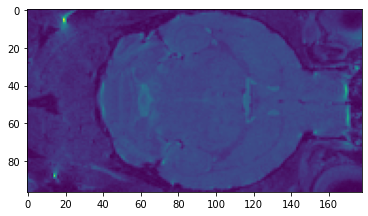

In [26]:
print('The scan:')
plt.imshow(sample['template'].detach().cpu().numpy()[0,0,:,:,50])

The brain mask:


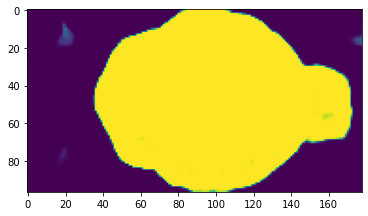

In [27]:
print('The brain mask:')
plt.imshow(out[0].detach().cpu().numpy()[0,0,:,:,50])

In our first run of this training loop, after 5 epochs we obtain this:

![5 Epochs brain mask](img/mymask.png)

As you can see, it seems the network is simply selecting high intensity areas! This is completely normal, and over time it learns to select only the ones delineating the brain volume. 

The background class:


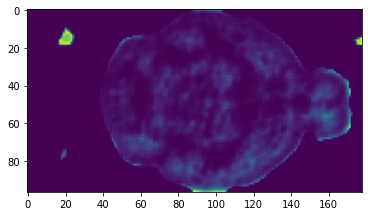

In [28]:
print('The background class:')
plt.imshow(out[1].detach().cpu().numpy()[0,20,:,:,50])

The background class seems to simply take over the remaining volume. This is again a reasonable preliminary approximation of the background class, and will be refined over time:

![Background class](img/bg.png)

Feel free to change the value on axis 1 in the next cell and plot the inferred probability maps for the remaining regions. Each channel corresponds to a new ROI. At this point, these should still be fairly nonsensical. It will take much longer before we can see any results.

![One random region probability map](img/roi.png)

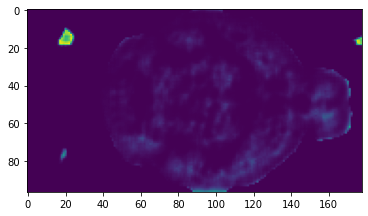

In [29]:
plt.imshow(out[1].detach().cpu().numpy()[0,1,:,:,50])

If you decided to skip the training step, you can start running cells again from the next one:

In [30]:
# Let's load the best model, according to the
# loss on the validation set, after training
# for 24 hour

checkpoint=torch.load('0_2000_savefile.pth',map_location=torch.device('cpu'))

# We will not need the optimizer's state dictionary,
# This would be useful to resume training

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
UN.load_state_dict(checkpoint['model_state_dict'])

# We randomly split samples between train and
# test set. To keep the same split, we should
# restore them as they were during training.

# If we could not hold the entire dataset in memory,
# we will just use what we have :)

if Max_Samples>=10:

    train_idxs, test_idxs=checkpoint['split']

    trainloader = torch.utils.data.DataLoader(dataset, batch_size=Bsize,
                                              sampler=torch.utils.data.SubsetRandomSampler(train_idxs))
    testloader = torch.utils.data.DataLoader(dataset, batch_size=Bsize,
                                             sampler=torch.utils.data.SubsetRandomSampler(test_idxs))
else:
    testloader = torch.utils.data.DataLoader(dataset, batch_size=Bsize)

# And let's extract one sample to test on:
sample=next(iter(testloader))

If not enough RAM is available, please refer to the output we previously generated:

Dice scores:

 [0.98867357 0.9950349  0.93097234 0.78294575 0.9327195  0.6305085
 0.78504676 0.7507003  0.9286715  0.9462388  0.8214787  0.8178052
 0.9202386  0.83711666 0.83189315 0.9470789  0.9144467  0.9279579
 0.96222526 0.8403756  0.90992695 0.82867783 0.93504506 0.9245333
 0.75736326 0.71347034 0.8147268  0.939434   0.95290637 0.88203686
 0.9013442  0.8970675  0.8332667  0.9488763  0.9133564  0.92734224
 0.86192995 0.89693505 0.8363352 ]

Average Dice score:  0.8760693


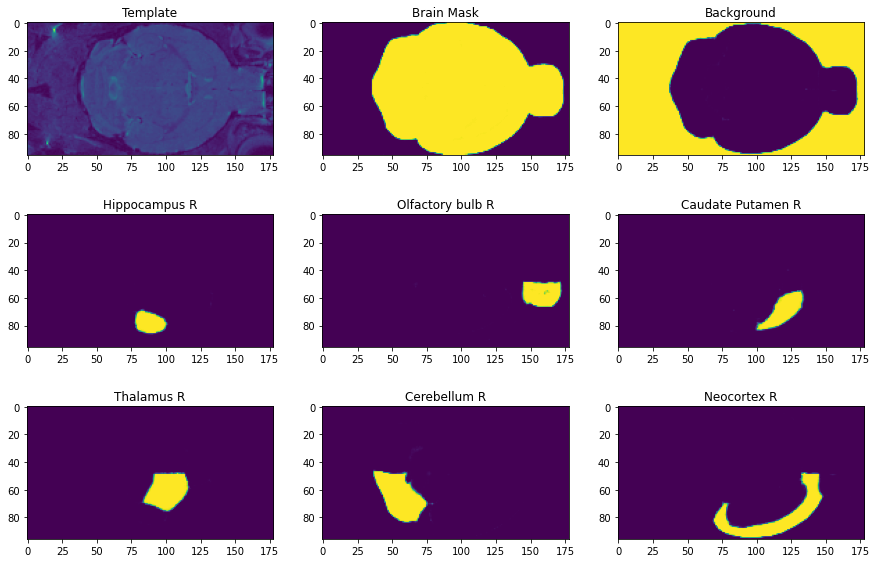

In [31]:
# Run this cell to evaluate the trained model

UN.eval()
with torch.no_grad(): # no need for gradient when evaluating
    torch.cuda.empty_cache()
    out=UN(sample['template'])
    true=(sample['mask'],sample['label'])

    loss = Loss(true,out)
    dices=FullDice(true,out)

print('Dice scores:\n\n',dices)
print('\nAverage Dice score: ',np.mean(dices))

plt.figure(figsize=(15,10))

plt.subplot(3, 3, 1)
plt.imshow(sample['template'].detach().cpu().numpy()[0,0,:,:,50])
plt.title('Template')

plt.subplot(3, 3, 2)
plt.imshow(out[0].detach().cpu().numpy()[0,0,:,:,50])
plt.title(labels[0])

plt.subplot(3, 3, 3)
plt.imshow(out[1].detach().cpu().numpy()[0,0,:,:,50])
plt.title(labels[1])

plt.subplot(3, 3, 4)
plt.imshow(out[1].detach().cpu().numpy()[0,1,:,:,50])
plt.title(labels[2])

plt.subplot(3, 3, 5)
plt.imshow(out[1].detach().cpu().numpy()[0,16,:,:,50])
plt.title(labels[17])

plt.subplot(3, 3, 6)
plt.imshow(out[1].detach().cpu().numpy()[0,3,:,:,50])
plt.title(labels[4])

plt.subplot(3, 3, 7)
plt.imshow(out[1].detach().cpu().numpy()[0,7,:,:,50])
plt.title(labels[8])

plt.subplot(3, 3, 8)
plt.imshow(out[1].detach().cpu().numpy()[0,8,:,:,50])
plt.title(labels[9])

plt.subplot(3, 3, 9)
plt.imshow(out[1].detach().cpu().numpy()[0,14,:,:,50])
plt.title(labels[15])

plt.show()

In this case we can see that the network learned to limit the brain mask to the brain volume. Beyond that, the ROIs we observe make sense and achieve overall good overlap with the ground truth. We can also see that the average overlap is lower than the one obtained for MU-Net originally, and in some ROIs is still around 0.5. We could improve this by training an ensamble of networks and averaging their outputs, expanding the training set, or trying out some regularization techniques.

In fact, you might be wondering why this network even works. The number of samples seems fairly limited for a deep neural network, right? We should think, however, of every segmented voxel as a sample, training the same parameters. In this way you can see that the number of samples is in fact rather large. 

As we are dealing with healthy brains, the distribution of our domain is rather narrow. For example, we know that in every image we will have an hippocampus, and it will be in the same relative position to the other ROIs in every scan. Compare this with the complexity of segmenting different categories on images acquired from a car as it moves throug many different streets in a variety of conditions and environment. Medical imaging presents different challenges, especially with regards to different medical contrasts and experimental settings, but in other ways can be more standardized than different image processing domains.

All in all, this tutorial is not meant to exhaust the vast number of possibilities involved in training a segmentation deep neural network, but I hope the concepts introduced during this time will help you enter this field and stimulate your curiosity. Feel free to go back up and play with the network parameters or further explore the outputs. Have fun!

## References:

#### Dataset: 
Ma D, Cardoso MJ, Modat M, Powell N, Wells J, Holmes H, Wiseman F, Tybulewicz V, Fisher E, Lythgoe MF, Ourselin S.  [Automatic structural parcellation of mouse brain MRI using multi-atlas label fusion.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0086576)  PloS one. 2014 Jan 27;9(1):e86576.

Ma D, Holmes HE, Cardoso MJ, Modat M, Harrison IF, Powell NM, O'Callaghan J, Ismail O, Johnson RA, O’Neill MJ, Collins EC., Mirza F. Beg, Karteek Popuri, Mark F. Lythgoe, and Sebastien Ourselin. [Study the longitudinal in vivo and cross-sectional ex vivo brain volume difference for disease progression and treatment effect on mouse model of tauopathy using automated MRI structural parcellation.](https://www.frontiersin.org/articles/10.3389/fnins.2019.00011) Frontiers in Neuroscience. 2019;13:11.

#### U-Net:
Ronneberger, O., Fischer, P., & Brox, T. (2015, October). [U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention](https://arxiv.org/abs/1505.04597) (pp. 234-241). Springer, Cham.

#### DeepNAT
Wachinger, C., Reuter, M., & Klein, T. (2018). [DeepNAT: Deep convolutional neural network for segmenting neuroanatomy.](https://www.sciencedirect.com/science/article/pii/S1053811917301465?casa_token=R3mHE2Hhy-UAAAAA:TO--bNXtACplQOJNgdCSfx6UJs-c0kjVZhGXTaPGm8RelVv3om7OE4WWhpEnsMsfWrg5CDyAUog) NeuroImage, 170, 434-445.

#### Multi-task U-Net
De Feo, R., Shantillo, A., Sierra, A., Valverde, J. M., Grohn, O., Giove, F., & Tohka, J. (2020). [Automated skull-stripping and segmentation with Multi-Task U-Net in large mouse brain MRI databases.](https://www.biorxiv.org/content/10.1101/2020.02.25.964015v1) (Preprint)


## Aknowledgements

The preparation of this tutorial has been supported by the European Social Fund project S21770 " Kuopio Biomedical Image Analysis Center (KUBIAC) - Enhancing the innovation potential by advancing the know-how on biomedical image analysis
